 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story 10](https://github.com/datacite/freya/issues/45) | As a funder, we want to be able to find all the outputs related to our awarded grants, including block grants such as doctoral training grants, for management info and looking at impact. 
 :------------- | :------------- | :-------------

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date. 

**Goal**: By the end of this notebook you should be able to:
- Retrieve all outputs of a grant award from a specific funder; 
- Plot number of outputs per month of the grant award duration;
- Display de-duplicated outputs in tabular format, including the number of their citations, views and downloads;
- Plot a pie chart of the number of outputs per resource type;
- Display an interactive chord plot of co-authorship relationships across all outputs.

## Install libraries and prepare GraphQL client

In [5]:
%%capture
# Install required Python packages
!pip install gql requests chord numpy

In [6]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run GraphQL query
Define the GraphQL query to find all outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) from [European Union](https://doi.org/10.13039/501100000780) to date.

In [7]:
# Generate the GraphQL query: find all outputs of FREYA grant award (https://cordis.europa.eu/project/id/777523) from funder (EU) to date
query_params = {
    "funderId" : "https://doi.org/10.13039/501100000780",
    "funderAwardQuery" : "fundingReferences.awardNumber:777523",
    "maxWorks" : 75
}

query = gql("""query getGrantOutputsForFunderAndAward($funderId: ID!, $funderAwardQuery: String!, $maxWorks: Int!)
{
funder(id: $funderId) {
  name
  works(query: $funderAwardQuery, first: $maxWorks) {
      totalCount
      nodes {
        id
        formattedCitation(style: "vancouver")
        titles {
          title
        }
        descriptions {
          description
        }        
        types {
          resourceType
        }
        dates {
          date
          dateType
        }
        versionOfCount
        creators {
          id
          name
        }
        fundingReferences {
          funderIdentifier
          funderName
          awardNumber
          awardTitle
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [8]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

## Display total number of works 
Display the total number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs to date.

In [9]:
# Get the total number of outputs to date
funder = data['funder']['works']
display(Markdown(str(funder['totalCount'])))

75

## Plot number of works per month
Display a bar plot of number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs to date, per each month of project's duration.

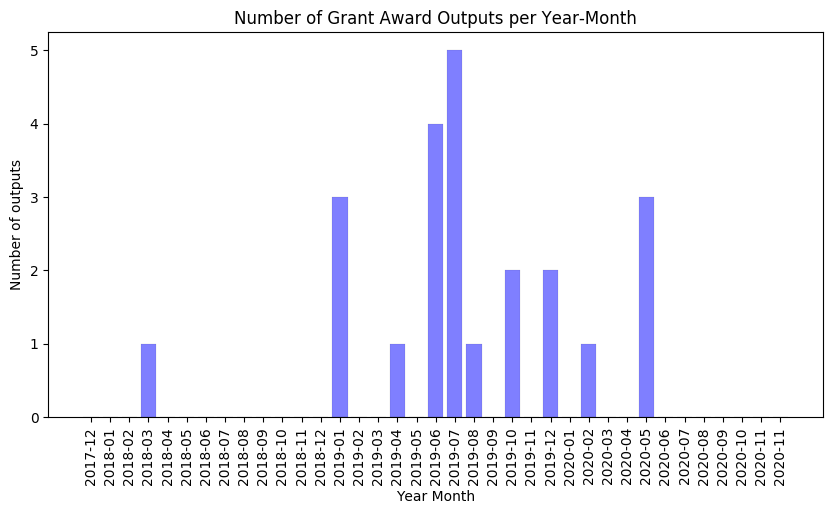

In [10]:
# Plot the number of FREYA outputs to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# Return month as String of two characters
def pad_month(month):
    str_month = None
    if (month <= 9):
        str_month = "0%d" % month
    else:
        str_month = "%d" % month
    return str_month

# Return list of consecutive years between min_year_month and max_year_month inclusive
def get_consecutive_year_months(min_year_month, max_year_month):
    year_months = ["%d%s%s" % (min_year_month[0],'-',pad_month(min_year_month[1]))]
    year_month = min_year_month
    while year_month != max_year_month:
        year = year_month[0]
        month = year_month[1]
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1
        year_month = (year, month)
        year_months.append("%d%s%s" % (year,'-',pad_month(month)))
    year_months.append("%d%s%s" % (max_year_month[0],'-',pad_month(max_year_month[1])))  
    return year_months

plt.rcdefaults()

# Retrieve works counts by month-year from nodes
# Pick out date of type: 'Issued'; failing that use 'Created' date.
num_outputs_dict = {}
funder = data['funder']['works']
for r in funder['nodes']:
    node_date = None
    for date_dict in r['dates']:
        ym = '-'.join(date_dict['date'].split('-')[0:2])
        if node_date is None:
            if date_dict['dateType'] in ['Issued', 'Created']:
                node_date = ym
        else:
            if date_dict['dateType'] in ['Issued']:
                node_date = ym
    if ym not in num_outputs_dict:
        num_outputs_dict[node_date] = 0
    num_outputs_dict[node_date] += 1;
    
# Sort works counts by month-year in chronological order
sorted_year_months = sorted(list(num_outputs_dict.keys()))
# Get all consecutive year-months FREYA-specific start-end year-months
year_months = get_consecutive_year_months((2017,12), (2020,11))       
# Populate non-zero counts for year_months                            
num_outputs = []
for ym in year_months:
    if ym in sorted_year_months:
        num_outputs.append(num_outputs_dict[ym])
    else:
        num_outputs.append(0)
        
# Generate a plot of number of grant outputs by year - month

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
x_pos = np.arange(len(year_months))
ax.bar(x_pos, num_outputs, align='center', color='blue', edgecolor='black', linewidth = 0.1, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(year_months, rotation='vertical')
ax.set_ylabel('Number of outputs')
ax.set_xlabel('Year Month')
ax.set_title('Number of Grant Award Outputs per Year-Month')
plt.show()


## Display de-duplicated works in tabular format
Display the outputs of [FREYA grant award](https://cordis.europa.eu/project/id/777523) in a html table, including the number of their citations, views and downloads. Note that the outputs are de-duplicated, i.e. outputs that are versions of another output are excluded.

In [11]:
from IPython.core.display import display, HTML
import textwrap
xstr = lambda s: 'General' if s is None else str(s)

# Get details for each output
outputs = [['ID','Type','Publication Date','Formatted Citation','Descriptions', 'Number of Citations', 'Number of Views', 'Number of Downloads']]
# Since there is scope for duplicates in Zenodo, versions of previously seen nodes are considered duplicates and stored in duplicate_versions so that 
# they can be excluded if seen later
for r in funder['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    # As Publication Date, pick out date of type: 'Issued'; failing that use 'Created' date.
    pub_date = None
    for date_dict in r['dates']:
        if pub_date is None:
            if date_dict['dateType'] in ['Issued', 'Created']:
                pub_date = date_dict['date'];
        else:
            if date_dict['dateType'] in ['Issued']:
                pub_date = date_dict['date'];
    
    titles = '; '.join([s['title'] for s in r['titles']])
    creators = '; '.join(['<a href="%s">%s</a>' % (s['id'],s['name']) for s in r['creators']])
    formatted_citation = "%s. %s. %s; Available from: %s" % (creators, titles, pub_date, id) 
    resource_type = xstr(r['types']['resourceType'])
    descriptions = textwrap.shorten('; '.join([s['description'] for s in r['descriptions']]), width=200, placeholder="...")
    output = [id, resource_type, pub_date, formatted_citation, descriptions, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table 
html_table = '<html><table>'   
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Publication Date,Formatted Citation,Descriptions,Number of Citations,Number of Views,Number of Downloads
10.5281/zenodo.1263942,General,2018-03-17,"Fenner, Martin; Crosas, Merce; Durand, Gustavo; Wimalaratne, Sarala; Gräf, Florian; Hallett, Richard; Bernal Llinares, Manuel; Schindler, Uwe; Clark, Tim. Listing of data repositories that embed schema.org metadata in dataset landing pages. 2018-03-17; Available from: 10.5281/zenodo.1263942",Machine-readable metadata available from landing pages for datasets facilitate data citation by enabling easy integration with reference managers and other tools used in a data citation workflow....,1,0,0
10.5281/zenodo.3248652,Project deliverable,2019-06-18,"Fenner, Martin; Wass, Joe; Demeranville, Tom; Wimalaratne, Sarala; Hallett, Richard. D2.2 PID Metadata Provenance. 2019-06-18; Available from: 10.5281/zenodo.3248652","The main focus of this document is describing the implementations of provenance tracking by the persistent identifier (PID) providers Crossref, ORCID, Identifiers.org (EMBL-EBI), and DataCite in...",1,0,0
10.5281/zenodo.2549228,Presentation,2019-01-25,"Reimer, Torsten; Madden, Frances. From Standard to Community Resource: A View on ISNIs and ORG IDs. 2019-01-25; Available from: 10.5281/zenodo.2549228","Over the last year, the International Standard Name Identifier board have been considering the ways in which ISNI as a system can improve to meet new challenges and become more open and...",0,0,0
10.5281/zenodo.3361511,Presentation,2019-07-16,"Brown, Christopher. RDA Europe Update. 2019-07-16; Available from: 10.5281/zenodo.3361511",Update presentation on the activities of RDA Europe from the RDA UK FREYA workshop on 16 July 2019.,0,0,0
10.5281/zenodo.3361398,Presentation,2019-07-16,"Brown, Christopher. JISC and PIDs. 2019-07-16; Available from: 10.5281/zenodo.3361398",Presentation outlining JISC's work relating to different persistent identifiers. Presented at the joint FREYA RDA UK Node Workshop 16 July 2019.,0,0,0
10.5281/zenodo.3564209,Presentation,2019-12-05,"Morselli, Francesca; Madden, Frances; Burton, Kath; Blaney, Jonathan. (Effectively) Communicating your research online presentations. 2019-12-05; Available from: 10.5281/zenodo.3564209","Presentations from the event (Effectively) Communicating your research online, held on 4 December 2019 at the Foundling Museum in London, UK. The event, aimed at early career researchers and PhD...",0,0,0
10.14454/3bpw-w381,Jupyter Notebook,2019-06-30,"Fenner, Martin. Jupyter Notebook FREYA PID Graph Key Performance Indicators (KPIs). 2019-06-30; Available from: 10.14454/3bpw-w381",,0,0,0
10.5438/wy92-xj57,BlogPosting,2019-04-10,"Fenner, Martin. Exposing DOI metadata provenance. 2019-04-10; Available from: 10.5438/wy92-xj57","DOI metadata provenance is describing the history of a particular DOI metadata record, i.e. what changes were made when and by whom. This information is now stored and provided via an API for all...",0,0,0
10.5281/zenodo.3361419,Presentation,2019-07-16,"Bunakov, Vasily. STFC case study: PhD research graph. 2019-07-16; Available from: 10.5281/zenodo.3361419","Presentation on an STFC example of a graph created to discover relationships between PhD metadata. Presented at the RDA UK FREYA workshop, 16 July 2019.",0,0,0
10.5281/zenodo.2549227,Presentation,2019-01-25,"Reimer, Torsten; Madden, Frances. From Standard to Community Resource: A View on ISNIs and ORG IDs. 2019-01-25; Available from: 10.5281/zenodo.2549227","Over the last year, the International Standard Name Identifier board have been considering the ways in which ISNI as a system can improve to meet new challenges and become more open and...",0,0,0


## Plot number of outputs per resource type
Plot as a pie chart the number of [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs per resource type.

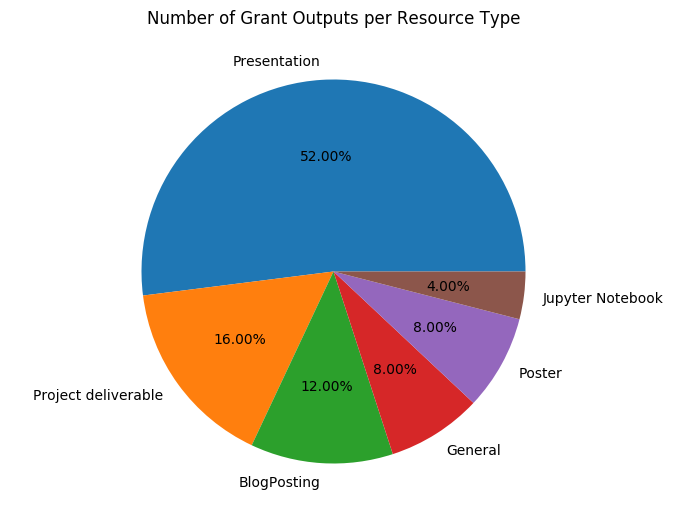

In [12]:
# Plot as a pie chart the number of outputs per resource type
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import operator

xstr = lambda s: 'General' if s is None else str(s)

plt.rcdefaults()

# Retrieve works counts by resource type from nodes
# Pick out date of type: 'Issued'; failing that use 'Created' date.
funder = data['funder']['works']
num_outputs_dict = {}
for r in funder['nodes']:
    resource_type = xstr(r['types']['resourceType'])
    if resource_type not in num_outputs_dict:
        num_outputs_dict[resource_type] = 0
    num_outputs_dict[resource_type] += 1;
    
# Sort resource types by count of work desc
sorted_num_outputs = sorted(num_outputs_dict.items(),key=operator.itemgetter(1),reverse=True)
# Populate lists needed for pie chart
resource_types = [s[0] for s in sorted_num_outputs] 
num_outputs = [s[1] for s in sorted_num_outputs] 

# Generate a pie chart of number of grant outputs by resource type
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of Grant Outputs per Resource Type')
ax.axis('equal')
ax.pie(num_outputs, labels = resource_types,autopct='%1.2f%%')
plt.show()

## Display an interactive plot of co-authorship relationships across all outputs
Display an interactive chord plot representing co-authorship relationships across all [FREYA grant award](https://cordis.europa.eu/project/id/777523) outputs.

In [218]:
# Generate a Chord plot representing co-authorship relationships across all grant award outputs
from chord import Chord       
from IPython.display import IFrame

all_creator_names_by_node = []
all_creator_names_set = set([])
funder = data['funder']['works']
for r in funder['nodes']:
    if r['versionOfCount'] > 0:
        # If the current output is a version of another one, exclude it
        continue
    creator_names = [s['name'] for s in r['creators']]
    all_creator_names_by_node.append(creator_names)
    all_creator_names_set.update(creator_names)
    
# Assemble data structures for the co-authorship chord diagram
all_creator_names = sorted(list(all_creator_names_set))

# Initialise chord data matrix
length = len(all_creator_names)
coauthorship_matrix = []
for i in range(length):
    r = []
    for j in range(length):
        r.append(0)
    coauthorship_matrix.append(r)
    
# Populate chord data matrix
for node_creators in all_creator_names_by_node:
    for creator in node_creators:
        c_pos = all_creator_names.index(creator)
        for co_creator in node_creators:
            co_pos = all_creator_names.index(co_creator)
            if c_pos != co_pos:
                coauthorship_matrix[c_pos][co_pos] += 1

# display co-authorship cord diagram
plot = Chord(coauthorship_matrix, all_creator_names, wrap_labels=False, margin=180, width=1000).to_html()
IFrame(src="./out.html", width=1000, height=1000)